This file is a new file wrtten by stav. In theis pipeline, the dataset is seperate, we will try to train on A dataset and test on B dataset(e).

Imports

In [1]:
import numpy as np
import random

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn import preprocessing
import math
from sklearn.metrics import fbeta_score
from numpy import arange
from sklearn.metrics import balanced_accuracy_score

In [2]:
metric_to_optimize = 'MCC'

In [3]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [4]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
def print_and_summarize_best_model(results,ml_results,best_models):
    ml_results = pd.concat([ml_results, results],sort=True)
    best_model_index = np.argmax(np.array(results[metric_to_optimize]))
    best_model = results.iloc[best_model_index]
    best_models = pd.concat([best_models, pd.DataFrame(best_model).transpose()],sort = True)
    
    return ml_results,best_models,best_model_index

In [6]:
def init_metrics():
    '''
    initialize the (empty) metrics structures
    :return: metrics_results
    '''
    metrics_results = {'FNR': None, 'FPR': None, 'MCC':None, 'ACC': None, 'F1score': None,'F2score': None}
    metrics_results['FNR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['FPR'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['MCC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['ACC'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F1score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    metrics_results['F2score'] = {'DT':None,'SVM':None,'RF':None,'NB': None,'KNN':None,'LogisticRegression':None}
    return metrics_results

def init_best_models():
    best_models = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return best_models

def init_ml_results():
    ml_results = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    return ml_results

In [29]:
def calculate_metrics(classifier_name,y_test,y_prediction,metrics_results,Type_test):
    '''
    calculate each metric for evaluation
    :param classifier_name: name of classifier used (svm, NB, etc)
    :param y_test:
    :param y_prediction:
    :param metrics_results:
    :return:
    '''
    from sklearn.metrics import matthews_corrcoef
    FNR_Leak = len(y_prediction[(Type_test =='Leak')& (y_prediction==0)])*1.00/len(Type_test[(Type_test =='Leak')])
    FNR_Clog = len(y_prediction[(Type_test =='Clog')& (y_prediction==0)])*1.00/len(Type_test[(Type_test =='Clog')])

    TN, FP, FN, TP = confusion_matrix(y_test, y_prediction).ravel()
      
    TPR = TP / (TP + FN)
    FPR  = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (FN + TP)
    F1_Score = fbeta_score(y_test, y_prediction, beta=1)
    F2_Score = fbeta_score(y_test, y_prediction, beta=2)
#     AUC = roc_auc_score(y_test, y_prediction,average='weighted')#average='weighted': Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label)
    MCC = matthews_corrcoef(y_test, y_prediction)
    Accuracy = accuracy_score(y_test, y_prediction)
    balanced_ACC = balanced_accuracy_score(y_test, y_prediction)

    metrics_results['FNR'][classifier_name] =  {'FNR':FNR,'Leak':FNR_Leak,'Clog':FNR_Clog,'balanced_ACC':balanced_ACC}
    metrics_results['FPR'][classifier_name] = FPR
    metrics_results['MCC'][classifier_name] = MCC
    metrics_results['ACC'][classifier_name] = Accuracy
    metrics_results['F1score'][classifier_name] = F1_Score
    metrics_results['F2score'][classifier_name] = F2_Score
    
    return metrics_results

In [8]:
def CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params):
    
    FNR_results, FPR_results, MCC_results, ACC_results,F1score_results,F2score_results = [],[],[],[],[],[]                      
    random.seed(10)
    skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    Type = data_labels['Type']
    data_labels = data_labels.drop("Type",axis=1)

    # K_folds:
    for train_index, test_index in skf.split(data, data_labels):
        x_train_fold, x_test_fold = data.iloc[train_index], data.iloc[test_index]
        y_train_fold, y_test_fold = data_labels.iloc[train_index], data_labels.iloc[test_index]
        Type_test = Type.iloc[test_index]

        if (Algorithm not in ['RF','DT']):
            if (Algorithm in('NB','svm_linear')):
                scaler = MinMaxScaler()
            else:
                scaler = StandardScaler()
            x_train_fold = scaler.fit_transform(x_train_fold)
            x_test_fold = scaler.fit_transform(x_test_fold)
            
        classifier.fit(x_train_fold, y_train_fold.values.ravel())
        y_prediction = classifier.predict(x_test_fold)
        metrics_results = calculate_metrics(Algorithm,y_test_fold,y_prediction,metrics_results,Type_test)
        FNR_results.append(metrics_results['FNR'][Algorithm])
        FPR_results.append(metrics_results['FPR'][Algorithm])
        MCC_results.append(metrics_results['MCC'][Algorithm])
        ACC_results.append(metrics_results['ACC'][Algorithm])
        F1score_results.append(metrics_results['F1score'][Algorithm])
        F2score_results.append(metrics_results['F2score'][Algorithm])
    results_summary = results_summary.append({'Algorithm':Algorithm,
                                              'model_index':model_index,
                                              'parameters':params,
                                              'FNR': {'FNR':sum(d['FNR'] for d in FNR_results) / len(FNR_results),
                                                     'FNR_Leak':sum(d['Leak'] for d in FNR_results) / len(FNR_results),
                                                     'FNR_Clog':sum(d['Clog'] for d in FNR_results) / len(FNR_results),
                                                     'balanced_ACC':sum(d['balanced_ACC'] for d in FNR_results) / len(FNR_results)},#np.mean(FNR_results),
                                              'FPR': np.mean(FPR_results),
                                              'MCC': np.mean(MCC_results),
                                              'ACC': np.mean(ACC_results),
                                              'F1score': np.mean(F1score_results),
                                              'F2score': np.mean(F2score_results)},
                                             ignore_index=True)
    return results_summary

In [9]:
def train_test_CV_LogisticRegression(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])

    Algorithm = 'LogisticRegression'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)
    cs = [0.1, 1, 10, 100]
    solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
    penalties_lbfgs_sag = ['l2', 'none']                # Used to specify the norm used in the penalization.
    penalties_liblinear = ['l1', 'l2']
    penalties_saga = ['l2', 'elasticnet', 'none']
    class_weight = 'balanced'
    multi_class = 'ovr'
    l1_ratio = []

    for s in solvers:
        if(s=='lbfgs' or s=='sag'):
            penalties = penalties_lbfgs_sag
        if(s=='liblinear'):
            penalties = penalties_liblinear
        if (s == 'saga'):
            penalties = penalties_saga
        for p in penalties:
            if (p == 'elasticnet'):
                l1_ratio = arange(0.01, 0.99, 0.01)
            for c in cs:
                for l1_r in l1_ratio:
                    classifier = LogisticRegression(penalty=p,C=c,class_weight='balanced',
                                                    random_state=0,multi_class='ovr',
                                                    solver=s,l1_ratio=l1_r,
                                                    max_iter=10000)  # create classifier
                    params = {"penalty": p,"C": c,"solver":s,"l1_ratio":l1_r}
                    results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)
                    model_index+=1
#     results_summary['model_index'] = results_summary['model_index'].astype(int)
#     results_summary = results_summary.set_index('model_index')
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results

In [10]:
def train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'RF'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)

    
    n_estimators = [200, 500]               # number of trees in the foreset
    max_depth = [5, 8, 10, 20]              # max number of levels in each decision tree
    criterion = ['gini', 'entropy']
    min_samples_split = [2, 5, 10, 15,20]   # min number of data points placed in a node before the node is split, used to control over-fitting
    bootstrap = [True, False]
    for n in n_estimators:
        for max in max_depth:
            for c in criterion:
                for min_sample in min_samples_split:
                    for b in bootstrap:
                        classifier = RandomForestClassifier(random_state=12,class_weight='balanced', n_estimators=n,
                                                            max_depth=max, criterion=c,min_samples_split=min_sample,bootstrap=b)  # class_weight: misclassifying the rare class is punished harsher.
                                           
                        params = {"n_estimators": n,"criterion": c,"min_samples_split":min_sample,"bootstrap":b,'max_depth':max}
                        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                        model_index+=1

    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results

In [11]:
def train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_linear'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)
    kernel = 'linear'
    cs = [0.1, 1, 10, 100]
    for c in cs:
        classifier = svm.SVC(probability=True,kernel=kernel,C=c,max_iter=100000)
        params = {"kernel": kernel,"C": c}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,
                                           metrics_results,results_summary,params)
        model_index+=1

    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [12]:
def train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_rbf'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)
    kernel =  'rbf'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4]
    for c in cs:
        for gamma in gammas:
            classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,max_iter=100000)
            params = {"kernel": kernel,"C": c,'gamma':gamma}
            results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

            model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [13]:
def train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'svm_poly'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)
    kernel = 'poly'
    cs = [0.1, 1, 10, 100]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1]
    degrees = [2,3,4,5]
    for c in cs:
        for gamma in gammas:
            for degree in degrees:
                classifier = svm.SVC(probability=True,kernel=kernel,C=c,gamma=gamma,degree=degree,max_iter=100000)
                params = {"kernel": kernel,"C": c,'gamma':gamma,'degree':degree}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [14]:
def train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'DT'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)
    
    criterion = ["gini", "entropy"]
    splitter = ["best", "random"]
    min_samples_split = [2, 5, 10, 15,20]  # min number of data points placed in a node before the node is split, used to control over-fitting
    for c in criterion:
        for s in splitter:
            for min_split in min_samples_split:
                classifier = tree.DecisionTreeClassifier(criterion=c,splitter=s,min_samples_split=min_split)
                params = {"criterion": c,"splitter": s,'min_samples_split':min_split}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [15]:
def train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'NB'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)
    NB_Classifiers = [GaussianNB(), MultinomialNB()]
    # CategoricalNB()
    for NB_clf in NB_Classifiers:
        classifier = NB_clf  # create classifier
        params = {"NB_Classifiers": NB_clf}
        results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,
                                       metrics_results,results_summary,params)
        model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [16]:
def train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results):
    model_index = int(1)
    results_summary = pd.DataFrame(columns=['Algorithm','model_index', 'parameters',
                                               'FNR','FPR','MCC','ACC','F1score','F2score'])
    Algorithm = 'KNN'
#     Type = data_labels['Type']
#     data_labels = data_labels.drop("Type",axis=1)
    n_neighbors = range(1, 11)
    weights = ['uniform', 'distance']
    Algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
    for n in n_neighbors:
        for w in weights:
            for alg in Algorithms:
                classifier = KNeighborsClassifier(n_neighbors=n,weights=w,algorithm=alg)  # create classifier
                params = {"n_neighbors": n,'weights':w,"Algorithm":alg}
                results_summary = CV_model_tunning(data,data_labels,classifier,Algorithm,model_index,metrics_results,results_summary,params)

                model_index+=1
    print(Algorithm,'_results_summary was created')
    results_summary.to_csv(folder_path_results+'\\'+Algorithm+'_results_summary.csv')
    ml_results,best_models,best_model_index = print_and_summarize_best_model(results_summary,ml_results,best_models)
    return ml_results,best_models,metrics_results   

In [24]:
def conduct_tunning_and_classification_for_each_family_model_CV(data,data_labels,stage):
    best_models = init_best_models()
    ml_results = init_ml_results()
    metrics_results = init_metrics()
    folder_path = 'C:\\Users\\Stav\\Desktop\\school\\2\\Research\\n\\Thesis\\BinaryB_testA'
    folder_path_results = folder_path+'\\classifiers'
    print('DecisionTree')
    ml_results,best_models,metrics_results = train_test_CV_DecisionTree(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('RandomForest')
    ml_results,best_models,metrics_results = train_test_CV_RandomForest(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('NaiveBayes')
    ml_results,best_models,metrics_results = train_test_CV_NaiveBayes(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('KNN')
    ml_results,best_models,metrics_results = train_test_CV_KNN(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_linear')
    ml_results,best_models,metrics_results = train_test_CV_svm_linear(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_rbf')
    ml_results,best_models,metrics_results = train_test_CV_svm_rbf(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    print('svm_poly')
    ml_results,best_models,metrics_results = train_test_CV_svm_poly(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    #print('LogisticRegression')
    #ml_results,best_models,metrics_results = train_test_CV_LogisticRegression(folder_path_results,data,data_labels,metrics_results,best_models, ml_results)
    
    best_models = pd.concat([best_models.drop(['FNR'], axis=1),best_models['FNR'].apply(pd.Series)], axis=1)
    ml_results = pd.concat([ml_results.drop(['FNR'], axis=1),ml_results['FNR'].apply(pd.Series)], axis=1)
   
    best_models = best_models.reindex(columns=['Algorithm',
                                               'model_index',
                                               'MCC',
                                               'ACC',
                                              'F1score',
                                              'F2score',
                                              'FNR',
                                              'FPR',
                                              'FNR_Leak',
                                              'FNR_Clog',
                                               'balanced_ACC']).reset_index().drop(['index'],axis=1)
    
    best_models.iloc[:,2:] = best_models.iloc[:,2:].round(5)
    best_models =best_models.set_index('Algorithm')
    best_models=best_models.T
    ml_results = ml_results.sort_values(by=[metric_to_optimize],ascending = False)  

    best_models.to_csv(folder_path+'\\best_models_include_malf_metrics.csv')
    ml_results.to_csv(folder_path+'\\ml_results_include_malf_metrics.csv')
    return ml_results,best_models,metrics_results

In [18]:
def RFECV_Random_Forest(X,y):
    from numpy import mean
    from numpy import std
    from sklearn.datasets import make_classification
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.feature_selection import RFECV
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import matthews_corrcoef
    import sklearn.metrics as m
    from sklearn.metrics import fbeta_score, make_scorer
    
    ftwo_scorer = make_scorer(fbeta_score, beta=2)

    # Automatically select the number of features for RFE
    # create pipeline
    rfe = RFECV(estimator=RandomForestClassifier())

    model = RandomForestClassifier()
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5, random_state=12)
    
    n_scores = cross_val_score(pipeline, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    rfe.fit(X, y)
    
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n of number of selected features")
    plt.plot(range(1, len(rfe.grid_scores_)+1), rfe.grid_scores_)
    plt.show()

    print('The optimal number of features is {}'.format(rfe.n_features_))
    features = [f for f,s in zip(X.columns, rfe.support_) if s]
    print('The selected features are:')
    print ('{}'.format(features))
    
    for i in range(X.shape[1]):
        print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    
    return features

In [20]:
df_A_B = pd.read_excel("C:\\Users\\Stav\\Desktop\\school\\2\\Research\\n\\DataBase-main\\results\\data_SdeDavid_afer_DataPreparation.xlsx").iloc[: , 1:] 
df_A_B.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    763 non-null    object 
 1   Plot                    763 non-null    object 
 2   Site_Name               763 non-null    object 
 3   prctile5                763 non-null    float64
 4   max                     763 non-null    float64
 5   prctile95               763 non-null    float64
 6   std                     763 non-null    float64
 7   MTD                     763 non-null    float64
 8   median                  763 non-null    float64
 9   kurtosis                763 non-null    float64
 10  IQR                     763 non-null    float64
 11  MAD                     763 non-null    float64
 12  meanci_1                763 non-null    float64
 13  meanci_2                763 non-null    float64
 14  Diff_median_of_plot     763 non-null    fl

In [21]:
df_A_B.describe()

,prctile5,max,prctile95,std,MTD,median,kurtosis,IQR,MAD,meanci_1,...,Diff_std_of_plot,Diff_mean_of_row,Diff_std_of_row,median_first_ring,median_second_ring,median_third_ring,median_core,CWSI,CWSI_minus_CWSI_of_row,Y
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,...,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,1.815280,13.513675,9.060669,2.228438,12.372962,3.089480,7.471718,1.767584,1.548733,3.704956,...,0.093633,-0.213084,0.073936,3.303276,3.042798,2.770858,2.627420,0.211528,-0.039910,0.815203
std,0.677107,0.582078,0.789572,0.169774,0.660876,0.739934,1.349287,0.355813,0.157738,0.703931,...,0.165729,0.485246,0.163905,0.817056,0.760323,0.740715,0.812760,0.148333,0.138255,0.739709
min,0.360045,12.309142,6.921428,1.795233,10.528896,1.310157,4.312554,0.829681,1.153332,2.126860,...,-0.361044,-1.436599,-0.369620,1.529818,1.219882,1.000201,0.685095,-0.149567,-0.444071,0.000000
25%,1.349959,13.133327,8.472272,2.110733,11.931104,2.550078,6.530766,1.520226,1.431462,3.217320,...,-0.015424,-0.547606,-0.038515,2.689895,2.522615,2.249923,2.050013,0.109931,-0.128640,0.000000
50%,1.669985,13.279070,8.985211,2.215859,12.359642,2.980196,7.390858,1.730118,1.543524,3.594838,...,0.102554,-0.222974,0.079956,3.199919,2.949930,2.729978,2.544969,0.195099,-0.041531,1.000000
75%,2.230012,13.769505,9.590305,2.343079,12.796275,3.569827,8.340078,1.999556,1.658786,4.134273,...,0.211232,0.140040,0.187425,3.835009,3.500110,3.250027,3.127427,0.297582,0.052864,1.000000
max,3.701030,15.020410,11.339797,2.717133,14.163963,5.330001,11.099643,2.839527,1.991453,5.837438,...,0.512076,1.169263,0.537098,5.840156,5.240020,4.839852,4.980050,0.668410,0.433775,2.000000


In [22]:
df_A_B.loc[df_A_B.Type == 'Clog', 'Y_binary'] =1 #malfunction
df_A_B.loc[df_A_B.Type == 'Leak', 'Y_binary'] = 1 #malfunction
df_A_B.loc[df_A_B.Type == 'Control', 'Y_binary'] = 0 

data_train = df_A_B[df_A_B.Plot=='e'].copy(True)
data_labels_train = data_train[['Y_binary','Type']]
data_test = df_A_B[df_A_B.Plot=='A'].copy(True)
data_labels_test = data_test[['Y_binary','Type']]
vars_to_drop = ["Site_Name",'Plot','Type','Y','Y_binary']

Accuracy: 0.756 (0.110)


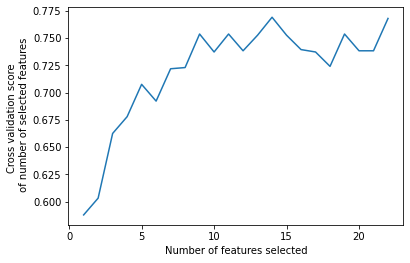

The optimal number of features is 14
The selected features are:
['prctile5', 'max', 'median', 'meanci_1', 'meanci_2', 'Diff_mean_of_plot', 'Diff_std_of_plot', 'Diff_mean_of_row', 'Diff_std_of_row', 'median_second_ring', 'median_third_ring', 'median_core', 'CWSI', 'CWSI_minus_CWSI_of_row']
Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 7.000
Column: 3, Selected False, Rank: 6.000
Column: 4, Selected False, Rank: 9.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected False, Rank: 5.000
Column: 7, Selected False, Rank: 3.000
Column: 8, Selected False, Rank: 4.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 2.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected False, Rank: 8.000
Column: 17, Selected True, Rank: 1.000
Column: 18

In [23]:
import random
random.seed(10)
features = RFECV_Random_Forest(data_train.drop(vars_to_drop,axis=1),data_labels_train['Y_binary'])



In [25]:
features = ['prctile5', 'max', 'median', 'meanci_1', 'meanci_2', 'Diff_mean_of_plot', 'Diff_std_of_plot', 'Diff_mean_of_row', 'Diff_std_of_row', 'median_second_ring', 'median_third_ring', 'median_core', 'CWSI', 'CWSI_minus_CWSI_of_row']

In [26]:
ml_results,best_models,metrics_results = conduct_tunning_and_classification_for_each_family_model_CV(data_train[features],data_labels_train,stage='B')

DecisionTree
DT _results_summary was created
RandomForest
RF _results_summary was created
NaiveBayes
NB _results_summary was created
KNN
KNN _results_summary was created
svm_linear
svm_linear _results_summary was created
svm_rbf
svm_rbf _results_summary was created
svm_poly
svm_poly _results_summary was created


In [27]:
best_models

Algorithm,DT,RF,NB,KNN,svm_linear,svm_rbf,svm_poly
model_index,17,19,1,77,1,12,15
MCC,0.414371,0.475375,0.292649,0.377472,0.0,0.316733,0.352725
ACC,0.71033,0.727912,0.658242,0.701538,0.603297,0.668571,0.624835
F1score,0.752081,0.75274,0.721289,0.766536,0.752193,0.721094,0.591499
F2score,0.74683,0.724819,0.739427,0.804993,0.883382,0.727489,0.507976
FNR,0.25333,0.28833,0.24556,0.165,0.0,0.26667,0.53444
FPR,0.345333,0.244,0.485333,0.501333,1.0,0.426667,0.128
FNR_Leak,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FNR_Clog,0.25333,0.28833,0.24556,0.165,0.0,0.26667,0.53444
balanced_ACC,0.70067,0.73383,0.63456,0.66683,0.5,0.65333,0.66878


## Evaluating model performence on independent data set (B)

In [30]:
results = init_metrics()
Algorithm = 'Random Forest'
params = {'n_estimators': 200, 'criterion': 'gini', 'min_samples_split': 5, 'bootstrap': True, 'max_depth': 20}
classifier = RandomForestClassifier(random_state=12,class_weight='balanced', n_estimators=200,
                                                            max_depth=20, criterion='gini',min_samples_split=5,bootstrap=True)  # class_weight: misclassifying the rare class is punished harsher.
                                           
classifier.fit(data_train[features],data_labels_train['Y_binary'])
y_prediction = classifier.predict(data_test[features])
results = calculate_metrics(Algorithm,data_labels_test['Y_binary'],y_prediction,results,data_labels_test['Type'])
results_summary = pd.DataFrame([[Algorithm,*list(params.values()),
                                      results['FNR'][Algorithm], results['FPR'][Algorithm],
                                     results['MCC'][Algorithm], results['ACC'][Algorithm],
                                     results['F1score'][Algorithm], results['F2score'][Algorithm]]],
            columns=['Algorithm',*list(params.keys()),'FNR','FPR', 'MCC', 'ACC','F1score','F2score'])

results_summary

,Algorithm,n_estimators,criterion,min_samples_split,bootstrap,max_depth,FNR,FPR,MCC,ACC,F1score,F2score
0,Random Forest,200,gini,5,True,20,"{'FNR': 0.17164179104477612, 'Leak': 0.1589403...",0.720137,0.129591,0.597122,0.704017,0.773699
